# endaq sensor parsing
## For questions, contact hartsell@fnal.gov

Paste in the sensor definitions from the "CM Transport instrumentation Checklist and Inventory CM<number>.xlsx as shown below and make sure all .IDE files in the format of "<SS#>_XXXX.IDE" are in the same directory as this notebook.
    
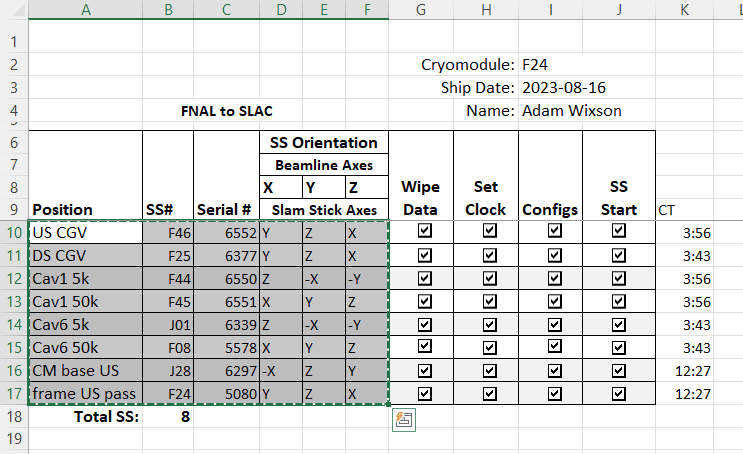
    
Configure options listed below.  Descriptions are given inline with the variable.

In [ ]:
'''
#Ensure pasting is done on the blank lines between the sets of """.  The """ should not have sensor data in that line.
#formatting example
sensor_def="""
US CGV	F46	6552	Y	Z	X
DS CGV	F25	6377	Y	Z	X
Cav1 5k	F44	6550	Z	-X	-Y
Cav1 50k	F45	6551	X	Y	Z
Cav6 5k	J01	6339	Z	-X	-Y
Cav6 50k	F08	5578	X	Y	Z
CM base US	J28	6297	-X	Z	Y
frame US pass	F24	5080	Y	Z	X
"""
'''

sensor_def="""
Cav1 50k	F45	6551	X	Y	Z
Cav2 50k	F99	6551	X	Y	Z
"""

#Options
tname="Descriptive name here"  #transport description, will be appended to all plot titles and file names
tstamp=1 #add time stamps to output for benchmarking
stepsize=0.05 #units of g, used for bin size in histogram.  0.05 for full shipment, larger for shorter.
spec=1.5 #units of g, flag any shocks higher than this level

In [ ]:
#initialization block

import csv
import os
import re
import sys
from tabulate import tabulate

from datetime import datetime 
import endaq.ide as ed
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd

print(f"Python Version: {sys.version}")

#Variable initialization where needed
out=[]

In [ ]:
#define colors for printing
class colors: 

    reset = '\033[0m'
    bold = '\033[01m'
    disable = '\033[02m'
    underline = '\033[04m'
    reverse = '\033[07m'
    strikethrough = '\033[09m'
    invisible = '\033[08m'

    class fg:
        black = '\033[30m'
        red = '\033[31m'
        green = '\033[32m'
        orange = '\033[33m'
 
    class bg:
        black = '\033[40m'
        red = '\033[41m'
        green = '\033[42m'
        orange = '\033[43m'

In [ ]:
def find_file(sensor):
    found=0
    filstart=sensor[1]
    for file in os.listdir("./"):
        if file.startswith(filstart):
            filname=file
            found=1
    if found==1:
        return filname
    else:
        return 0

In [ ]:
#Main code block

out=[["Sensor", "Axis", "Pass/Fail", "Stddev 0.1-1g", "Points over 1.5g/hour", "Points over 3g/hour"]]
start=datetime.now()
if tstamp: print(f"Start at {start}.")

# format the sensors input into something usable
sensors=[line.split('\t') for line in sensor_def.split('\n')]
sensors=sensors[1:len(sensors)-1]  #removes blank first and last entries from the multiline string method

for sensor in sensors:
    filname=find_file(sensor)
    if filname==0: 
        print(f"{colors.fg.red}{colors.bold}Did not find a file for {sensor}.{colors.reset}")
        out.append([sensor[0], labels[i], f"{colors.fg.red}{colors.bold}File Not Found{colors.reset}"])
        continue
    dirs=[]
    if tstamp: print(f"Opening {filname} at {datetime.now()}")
    
    sens=ed.get_primary_sensor_data(name=filname, measurement_type="ACCELERATION", criteria='samples', time_mode='timedelta')

    if tstamp: print(f"Opened {filname} at {datetime.now()}")
        
    for i in range(3):  #loops over the 3 axes of channels in the data file
        flag=0
        
        # this defines an order for arranging the time series plots
        order={'X':0, 'Y':1, 'Z':2}
        labels=["X", "Y", "Z"]

        if "-" in sensor[i+3]:  #handles inversion if needed and removing negative sign
            print(f"Needed to rotate for {sensor[0]} {sensor[i+3]}")
            sensor[i+3]=sensor[i+3][-1]
            flag=1
        
        axis=order[sensor[i+3]]
        filter = sens.columns.str.contains(sensor[i+3])
        accel=sens.loc[:, filter]

        if flag==1:
            accel=accel*-1
            flag=0

        if tstamp: print(f"Resampling {sensor[0]} {sensor[i+3]} at: {datetime.now()}")

        #set up for time series
        #desample to 1Hz max/min for easy plotting
        dsample=accel.resample('1s').agg(['max', 'min'])

        #this is unexpected behavior, why do we get mins when calling max and max when calling min?
        dsamplemin=dsample[max].to_numpy().flatten()
        dsamplemax=dsample[min].to_numpy().flatten()
        #remove DC components
        dcremovemin=dsamplemin-np.median(dsamplemin)  
        dcremovemax=dsamplemax-np.median(dsamplemax)  

        if i==0:
            #set up histogram plot as figure 0
            plt.figure(0,figsize=[12,8], dpi=150)
            plt.style.use('seaborn-v0_8-notebook')
            plt.xlabel("Acceleration (g)")
            plt.ylabel("Counts")

            #set up time series plots as figure 1
            gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]) 
            plt.figure(1,figsize=[12,8], dpi=200)
            plt.style.use('seaborn-v0_8-notebook')
            plt.suptitle(f"{tname} {sensor[0]} Combined Timeseries")

        # plot histogram
        if tstamp: print(f"Plotting {sensor[0]} {sensor[i+3]} histogram at: {datetime.now()}")
        plt.figure(0)
        acc=accel.to_numpy().flatten()
        del accel
        bins=np.arange(np.trunc(acc.min()-np.median(acc))-1,np.trunc(acc.max()-np.median(acc))+1,stepsize)
        plt.hist(acc-np.median(acc), bins, histtype='step', log=True, lw=2, label=labels[i])
        
        #plot timeseries
        if tstamp: print(f"Plotting {sensor[0]} {labels[i]} tseries at: {datetime.now()}")
        time=dsample.index.to_numpy().astype(np.float32)/float(1e9)/3600 #convert to hours
        timeend=time[-1]
        plt.figure(1)
        ax1=plt.subplot(gs[order[labels[i]]])
        plt.plot(time, dsamplemin, lw=1)
        plt.plot(time, dsamplemax, lw=1)
        plt.grid()
        plt.ylabel(f"{labels[i]} Acceleration (g)")

        #Calculations per Chris Adolphson
        if tstamp: print(f"Running Calcs on {sensor[0]} {sensor[i+3]} at: {datetime.now()}")
        accabs=np.absolute(acc-np.median(acc))
        del acc
        
        #Std deviation of 0.1g<x<1g
        cond=[(accabs>0.1) & (accabs<1)]
        choice=[accabs]
        std1=np.std(np.select(cond, choice))
        
        #Data points of x>1.5g per hour
        cond=[(accabs>1.5)]
        choice=[accabs]
        gt1=(np.extract(cond, choice)).size/timeend
        
        #Data points x>3g per hour
        cond=[accabs>3]
        choice=[accabs]
        gt3=(np.extract(cond, choice)).size/timeend
        
        del accabs

        #Check criteria
        if float(dcremovemin.min()) < -spec or float(dcremovemax.max()) > spec:
            outstr=f"{colors.fg.red}{colors.bold}WARNING!{colors.reset} {sensor[0]} {labels[i]} over {str(spec)}g specification"
            print(outstr)
            out.append([sensor[0], labels[i], f"{colors.fg.red}{colors.bold}WARNING!{colors.reset}", std1, gt1, gt3])
        else:
            outstr=f"{colors.fg.green}OK {colors.reset}{sensor[0]} {labels[i]} PASS."
            print(outstr)
            out.append([sensor[0], labels[i], f"{colors.fg.green}PASS{colors.reset}", std1, gt1, gt3])

    #finish up some things on the histogram plot
    plt.figure(0)
    plt.xlabel("Acceleration (g)")
    plt.ylabel("Counts")
    plt.ylim(bottom=0.9)
    plt.legend()
    plt.grid()
    plt.title(f"{tname} {sensor[0]} Combined Histogram")
    plt.savefig(f"{tname} {sensor[0]} Combined Histogram.png", bbox_inches="tight", dpi=150)

    #finish up some things on the time series plots
    plt.figure(1)
    ax1=plt.subplot(gs[2])
    plt.xlabel("Time since start (hours)")
    plt.savefig(f"{tname} {sensor[0]} Combined Timeseries.png", bbox_inches="tight", dpi=150)

    plt.show()
    plt.close()
        
if tstamp: print(f"Total run time: {datetime.now()-start}.")

In [ ]:
#Print the summary output and save
print(tabulate(out, headers="firstrow", floatfmt=".4f"))

#Save summary output
filname=tname+" statistics.csv"
with open(filname, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(out)